In [2]:
"""
This example shows how to perform regression of molecular properties with a
database of the atomic geometry of water clusters with an associated energy, 
using a simple GNN in disjoint mode.
"""

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mendeleev import H, O
import math

# Install matplotlib inside the virtual env
#import pip
#pip.main(["install","matplotlib"])
import matplotlib.pyplot as plt

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.datasets import QM9
from spektral.layers import GCSConv, ECCConv, GlobalSumPool, MessagePassing, GATConv, CrystalConv, GlobalAttnSumPool

#from spektral.utils import normalized_adjacency

2023-01-26 11:53:35.176675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 11:53:35.336175: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-26 11:53:35.985796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-26 11:53:35.985839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
#learning_rate = 1e-4  # Learning rate
epochs = 200  # Number of training epochs
batch_size = 1  # Batch size

initial_learning_rate = 1e-3
#learning_rate = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=initial_learning_rate, decay_steps=epochs/10, decay_rate=0.8)
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,
                decay_steps=epochs/10, decay_rate=0.8)
#learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,
#    decay_steps=epochs/10, decay_rate=0.7)

#learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=10, min_lr=1e-5)



"""
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate_initial,
    decay_steps=epochs,
    decay_rate=0.98)
"""


'\nlearning_rate = tf.keras.optimizers.schedules.ExponentialDecay(\n    initial_learning_rate=learning_rate_initial,\n    decay_steps=epochs,\n    decay_rate=0.98)\n'

In [4]:
################################################################################
# Load data and make graphs
################################################################################
class MyDataset(Dataset):
    """
    A dataset of graphs obtained from the atomic positions of water
    clusters with size between 20 and 237 water molecules, each of them
    associated to an energy value.
    """

    def __init__(self, r2_cutoff, n_dim = 3, **kwargs):

        self.r2_cutoff = r2_cutoff
        self.n_dim = n_dim

        # path of the atomic geometry files
        self.geometry_paths = []
        #data_dir = "../dataset_WaterClusters_big/"
        data_dir = "../dataset_WaterClusters/"
        #for N in [20,32,47,76,100,139,190,237]:
            #for temp in [100,150,200]:
                #for MDstep in ["0500.dat","1000.dat","1500.dat","2000.dat"]:
                    #geometry_path = data_dir+"N"+str(N)+"-T"+str(temp)+"/"+str(MDstep)
                    #self.geometry_paths.append(geometry_path)
        for folder in os.listdir(data_dir): 
            dir_name = os.path.join(data_dir,folder)
            for file_name in os.listdir(dir_name):
                geometry_path = os.path.join(dir_name,file_name)
                self.geometry_paths.append(geometry_path)

        self.n_samples = len(self.geometry_paths)

        self.Epm_avrg = 0.0
        self.Epm_dev = 0.0
        self.E_avrg = 0.0
        self.E_dev = 0.0
        self.xmax = 22.0
        self.Emax = 0
        self.Emin = 0

        self.num_node_features = 0
        self.num_edge_features = 0
        self.num_labels = 0
                
        super().__init__(**kwargs)

    def read(self):

        def compute_Eavrg():

            # Compute the average energy per molecule among all the clusters

            Epm_avrg = 0.0
            E_avrg = 0.0
            Emax = 0.0
            Emin = 1E6
            
            for ii in range(self.n_samples):
            
                geom_path = self.geometry_paths[ii]
                gfile = open(geom_path,'r')
                line = gfile.readline()
                n_molecules = int(gfile.readline())
                line = gfile.readline()
                line = gfile.readline()
                line = gfile.readline()
                columns = line.split()
                energy = float(columns[0])
                gfile.close()

                Epm_avrg = Epm_avrg + energy / float(n_molecules)
                E_avrg = E_avrg + energy
                if(energy>Emax): Emax = energy
                if(energy<Emin): Emin = energy
                

            Epm_avrg = Epm_avrg / float(self.n_samples)
            E_avrg = E_avrg / float(self.n_samples)
            
            self.Epm_avrg = Epm_avrg
            self.E_avrg = E_avrg
            self.Emax = Emax
            self.Emin = Emin

            print("E_avrg: "+str(E_avrg))

        def compute_Edev():

            # Compute standard deviation from Epm_avrg

            Epm_dev = 0.0
            E_dev = 0.0

            for ii in range(self.n_samples):
            
                geom_path = self.geometry_paths[ii]
                gfile = open(geom_path,'r')
                line = gfile.readline()
                n_molecules = int(gfile.readline())
                line = gfile.readline()
                line = gfile.readline()
                line = gfile.readline()
                columns = line.split()
                energy = float(columns[0])
                gfile.close()

                Epm_dev = Epm_dev + ( energy / float(n_molecules) - self.Epm_avrg )**2
                E_dev = E_dev + ( energy - self.E_avrg )**2

            Epm_dev = np.sqrt( Epm_dev / float(self.n_samples) )
            E_dev = np.sqrt( E_dev / float(self.n_samples) )

            self.Epm_dev = Epm_dev
            self.E_dev = E_dev

            print("E_dev: "+str(E_dev))
            
        def make_graph(isample):

            # Process the header of the geometry file
            geom_path = self.geometry_paths[isample]
            gfile = open(geom_path,'r')
            line = gfile.readline()
            n_molecules = int(gfile.readline())
            line = gfile.readline()
            line = gfile.readline()
            line = gfile.readline()
            columns = line.split()
            energy = float(columns[0])
            line = gfile.readline()
            line = gfile.readline()            

             
            # Node features (atom type and position [x,y,z])            
            n_nodes = 3*n_molecules
            #num_node_features = 1 + self.n_dim
            num_physical_features = 7
            num_abstract_features = 0
            num_node_features = num_physical_features + num_abstract_features
            self.num_node_features = num_node_features
            x = np.zeros((n_nodes, num_node_features))
            pos = np.zeros((n_nodes, 3))
            for inode in range(n_nodes):
                line = gfile.readline()
                columns = line.split()
                if (inode%3==0): # oxygen atom
                    #x[inode,0] = 1.0   
                    x[inode,0] = O.atomic_number
                    x[inode,1] = O.atomic_radius
                    x[inode,2] = O.covalent_radius
                    x[inode,3] = O.vdw_radius
                    x[inode,4] = O.dipole_polarizability
                    x[inode,5] = O.electron_affinity
                    x[inode,6] = O.en_pauling 
                    #for ifeat in range(num_abstract_features):
                            #wi = (ifeat+1) * np.pi
                            #wi = (ifeat+1)
                            #x[inode,7+ifeat] = np.sin(wi*O.atomic_weight)
                else:            # hydrogen atom
                    #x[inode,0] = 0.0    
                    x[inode,0] = H.atomic_number
                    x[inode,1] = H.atomic_radius
                    x[inode,2] = H.covalent_radius
                    x[inode,3] = H.vdw_radius
                    x[inode,4] = H.dipole_polarizability
                    x[inode,5] = H.electron_affinity
                    x[inode,6] = H.en_pauling
                    #for ifeat in range(num_abstract_features):
                            #wi = (ifeat+1) * np.pi
                            #wi = (ifeat+1)
                            #x[inode,7+ifeat] = np.sin(wi*H.atomic_weight)
                pos[inode,0:] = columns[1:]
                #x[inode,1:] = pos[inode,0:]
                #x[inode,1:] = x[inode,1:] / float(self.xmax)
                #x[inode,1:] = np.random.random(num_abstract_features)
            gfile.close()     

            """ # Node features (atom type and position [x,y,z])            
            n_nodes = 3*n_molecules
            num_node_features = 1
            self.num_node_features = num_node_features
            x = np.zeros((n_nodes, num_node_features))
            pos = np.zeros((n_nodes, 3))
            for inode in range(n_nodes):
                line = gfile.readline()
                columns = line.split()
                if (inode%3==0): # oxygen atom
                    #x[inode,0] = 1.0   
                    x[inode,0] = O.atomic_number/O.atomic_number
                else:            # hydrogen atom
                    #x[inode,0] = 0.0    
                    x[inode,0] = H.atomic_number/O.atomic_number
                pos[inode,0:] = columns[1:]
                #x[inode,1:] = pos[inode,0:]
                #x[inode,1:] = x[inode,1:] / float(self.xmax)
                #x[inode,1:] = np.random.random(num_abstract_features)
            gfile.close()                 """

            # Binary Adjacency matrix (two nodes/atoms are connected if rij2 < r2_cutoff)
            a = np.zeros((n_nodes,n_nodes))
            n_edges = 0
            n_neighbors_mean = 0
            for iatom in range(3*n_molecules):
                n_neighbors = 0
                for jatom in range(iatom+1,3*n_molecules):
                    rij = pos[iatom,0:] - pos[jatom,0:]
                    r2 = np.dot(rij,rij)
                    if (r2 <= self.r2_cutoff):
                        n_neighbors = n_neighbors +1
                        #print(iatom,jatom,r2)                        
                        #a[iatom,jatom] = np.sqrt(r2)
                        a[iatom,jatom] = 1
                        n_edges = n_edges + 1       
                n_neighbors_mean = n_neighbors_mean + n_neighbors
                #print("atom "+str(iatom)+" has "+str(n_neighbors)+" neighbors")     
            n_neighbors_mean = n_neighbors_mean / iatom
            print("n_neighbors_mean: "+str(n_neighbors_mean))
            a = np.maximum(a, a.T)#.astype(int) # Adjacency matrix is symetric in this case
            a = sp.csr_matrix(a)
            #a = normalized_adjacency(a, symmetric=True)

            """ # Edge features (type of bonding: O-O, H-O, H-H)
            n_edges = n_edges*2  # all pairs
            num_abstract_features = 0
            L_param = 3
            M_param = 3
            num_physical_features = L_param * M_param * 2
            num_edge_features = num_physical_features + num_abstract_features
            self.num_edge_features = num_edge_features
            e = np.zeros((n_edges,num_edge_features))
            id_edge = 0
            for iatom in range(3*n_molecules):
                for jatom in range(3*n_molecules):
                    if(iatom!=jatom):
                        rij = pos[iatom,0:] - pos[jatom,0:]
                        r2 = np.dot(rij,rij)
                        if (r2 <= self.r2_cutoff):
                            r = np.sqrt(r2)
                            rc = np.sqrt(self.r2_cutoff)
                            #print(iatom,jatom,r2)
                            ifeat = 0
                            for iL in range(L_param):
                                for iM in range(M_param):
                                    fac = iL*(r/rc)**iM /math.factorial(iM)
                                    e[id_edge,ifeat] = np.sin(fac)
                                    e[id_edge,ifeat+1] = np.cos(fac)
                                    ifeat = ifeat+2
                            #e[id_edge,1:] = np.random.random(num_abstract_features)
                            id_edge = id_edge + 1 """

            # Edge features (type of bonding: O-O, H-O, H-H)
            n_edges = n_edges*2  # all pairs
            num_edge_features = 1
            self.num_edge_features = num_edge_features
            e = np.zeros((n_edges,num_edge_features))
            id_edge = 0
            for iatom in range(3*n_molecules):
                for jatom in range(3*n_molecules):
                    if(iatom!=jatom):
                        rij = pos[iatom,0:] - pos[jatom,0:]
                        r2 = np.dot(rij,rij)
                        if (r2 <= self.r2_cutoff):
                            r = np.sqrt(r2)
                            rc = np.sqrt(self.r2_cutoff)
                            e[id_edge,0] = r/rc
                            #print(iatom,jatom,r2)
                            #e[id_edge,1:] = np.random.random(num_abstract_features)
                            id_edge = id_edge + 1                            
            
            # Labels
            num_labels = 1
            self.num_labels = num_labels
            y = np.zeros(num_labels,)
            y[0,] = energy
            #y[0,] = ( energy / float(n_molecules) - self.Epm_avrg ) / self.Epm_avrg
            #y[0,] = ( energy / float(n_molecules) - self.Epm_avrg ) / self.Epm_dev
            #y[0,] = ( energy - self.E_avrg ) / self.E_dev
            #y[0,] = energy - self.E_avrg
            #y[0,] = ( energy - self.E_avrg ) / self.E_dev * 100
            #y[0,] = energy * 100

            #ca = 1.0/(self.Emax-self.Emin)
            #cb = -self.Emin/(self.Emax-self.Emin)
            #y[0,] = ca*energy + cb

            print(str(geom_path)+"    Energy "+str(y[0,]))
            
            return Graph(x=x, a=a, e=e, y=y)

        # Compute average of the energy per molecule
        compute_Eavrg()
        compute_Edev()
        # We must return a list of Graph objects
        return [make_graph(isample) for isample in range(self.n_samples)]        


In [171]:
######################################################
# Initialize model
######################################################

# Generate dataset from atomic geometry files
d_cutoff = 6.0
d2_cutoff = d_cutoff * d_cutoff
dataset = MyDataset( d2_cutoff )

# Parameters
F = dataset.num_node_features  # Dimension of node features
S = dataset.num_edge_features  # Dimension of edge features
n_out = dataset.num_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.8 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

#loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size)
#loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size)
# we set epochs=epochs within loader_te to check loss on test set
#loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=epochs+1)

E_avrg: -1.6378342438541669
E_dev: 1.2369982465197895
n_neighbors_mean: 4.491525423728813
../dataset_WaterClusters/N20-T150/0500.dat    Energy -0.25955347
n_neighbors_mean: 4.271186440677966
../dataset_WaterClusters/N20-T150/2000.dat    Energy -0.25603255
n_neighbors_mean: 4.440677966101695
../dataset_WaterClusters/N20-T150/1500.dat    Energy -0.25106678
n_neighbors_mean: 4.220338983050848
../dataset_WaterClusters/N20-T150/1000.dat    Energy -0.24915115
n_neighbors_mean: 4.389473684210526
../dataset_WaterClusters/N32-T150/0500.dat    Energy -0.40419989
n_neighbors_mean: 4.326315789473684
../dataset_WaterClusters/N32-T150/2000.dat    Energy -0.38739953
n_neighbors_mean: 4.536842105263158
../dataset_WaterClusters/N32-T150/1500.dat    Energy -0.41271231
n_neighbors_mean: 4.347368421052631
../dataset_WaterClusters/N32-T150/1000.dat    Energy -0.37491919
n_neighbors_mean: 5.127090301003345
../dataset_WaterClusters/N100-T150/0500.dat    Energy -1.53129312
n_neighbors_mean: 5.297658862876254


In [172]:
################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        #self.conv1 = ECCConv(32, activation="relu")
        #self.conv2 = ECCConv(32, activation="relu")
        #self.conv1 = GCSConv(32, activation="relu")
        #self.conv2 = GCSConv(32, activation="relu")
        #self.conv1 = GCSConv(64, activation="tanh")
        #self.conv2 = GCSConv(64, activation="tanh")
        #self.conv3 = GCSConv(64, activation="tanh")
        #self.conv1 = CrystalConv(aggregate="sum",activation="sigmoid")
        #self.conv2 = CrystalConv(aggregate="sum",activation="sigmoid")
        self.conv1 = CrystalConv(aggregate="sum",activation="tanh")
        self.conv2 = CrystalConv(aggregate="sum",activation="tanh")
        #self.conv1 = GATConv(8,attn_heads=7,dropout_rate=0)
        #self.conv2 = GATConv(8,attn_heads=7,dropout_rate=0)
        self.global_pool = GlobalSumPool()
        #self.global_pool = GlobalAttnSumPool()
        self.dense1 = Dense(128,activation="tanh")
        self.dense2 = Dense(128,activation="tanh")
        self.dense3 = Dense(n_out)
        #self.dense3 = Dense(n_out,activation="sigmoid")
        #self.dense3 = Dense(num_nodes)
        #self.global_pool = GlobalSumPool()
        #self.global_pool = GlobalAttnSumPool()
        #self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        #x, a, i = inputs
        #x = self.conv1([x, a])
        #x = self.conv2([x, a])
        #x = self.conv3([x, a])
        output = self.global_pool([x, i])
        output = self.dense1(output)
        output = self.dense2(output)
        output = self.dense3(output)
        #output = self.global_pool([output, i])
        #output = self.dense(output)

        return output

model = Net()
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()
#loss_fn = MeanAbsoluteError()
#loss_fn = MeanAbsolutePercentageError()

In [173]:
################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

outfile = open("loss.dat",'w')
nepoch = 1
step = loss = 0
loss_train = []
#loss_test = []
#loss_te = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print(str(nepoch)+" Loss: {}".format(loss / loader_tr.steps_per_epoch))
        outfile.write(str(nepoch)+" {}".format(loss / loader_tr.steps_per_epoch)+" \n")
        loss_train.append(loss / loader_tr.steps_per_epoch)
        if(nepoch==epochs): break
        nepoch = nepoch + 1

        # log the loss into wandb
        #wandb.log({"loss": loss / loader_tr.steps_per_epoch})
        
        loss = 0

        """
        # Loss on test set
        batch_te = next(iter(loader_te))
        inputs, target = batch_te
        predictions = model(inputs, training=False)
        #loss_te += loss_fn(target, predictions)
        loss_te = loss_fn(target, predictions)
        #loss_te /= loader_te.steps_per_epoch
        loss_test.append(loss_te)
        #loss_te = 0
        """

outfile.close()

# Plot Loss Function on Training Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_train)
plt.plot(range(1,epochs+1),loss_train,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

"""
# Plot Loss Function on Test Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_test)
plt.plot(range(1,epochs+1),loss_test,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()
"""


/home/alfonso/Work/UGR/Calculations/WaterClusters_GNNs/GNNs_WaterClusters_venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
/home/alfonso/Work/UGR/Calculations/WaterClusters_GNNs/GNNs_WaterClusters_venv/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1 Loss: 2.2669341564178467
2 Loss: 1.7012062072753906
3 Loss: 1.7145940065383911
4 Loss: 1.6467145681381226
5 Loss: 1.635330080986023
6 Loss: 1.6319166421890259
7 Loss: 1.6261001825332642
8 Loss: 1.622101902961731
9 Loss: 1.6194607019424438
10 Loss: 1.6192009449005127
11 Loss: 1.6188896894454956
12 Loss: 1.6188493967056274
13 Loss: 1.6187900304794312
14 Loss: 1.6188011169433594
15 Loss: 1.6187822818756104
16 Loss: 1.6187809705734253
17 Loss: 1.6187809705734253
18 Loss: 1.6187810897827148
19 Loss: 1.6187810897827148
20 Loss: 1.6187810897827148
21 Loss: 1.6187808513641357
22 Loss: 1.6187810897827148
23 Loss: 1.6187809705734253
24 Loss: 1.6187808513641357
25 Loss: 1.6187810897827148
26 Loss: 1.6187810897827148
27 Loss: 1.6187810897827148
28 Loss: 1.6187810897827148
29 Loss: 1.618781328201294
30 Loss: 1.6187810897827148
31 Loss: 1.6187812089920044
32 Loss: 1.6187810897827148
33 Loss: 1.6187810897827148
34 Loss: 1.6187810897827148
35 Loss: 1.6187806129455566
36 Loss: 1.6187810897827148
37 L

KeyboardInterrupt: 

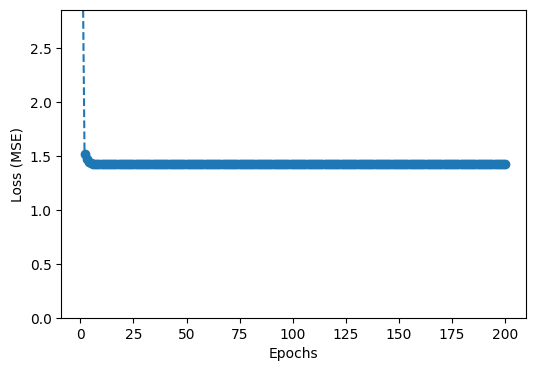

In [165]:
# Plot Loss Function on Training Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_train)
plt.plot(range(1,epochs+1),loss_train,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
ymedian = np.median(loss_train)
#plt.xlim(0,200)
plt.ylim(0,ymedian*2)
plt.show()

In [166]:
################################################################################
# Evaluate model
################################################################################

# Loss on Test Set. Predicted vs Real energies
print("Testing model")
loss = 0
ypred = []
ytrue = []
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    loss += loss_fn(target, predictions)
    ypred.append(predictions)
    ytrue.append(target)
    break
loss /= loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))


Testing model
Done. Test loss: 3.486901186988689e-05


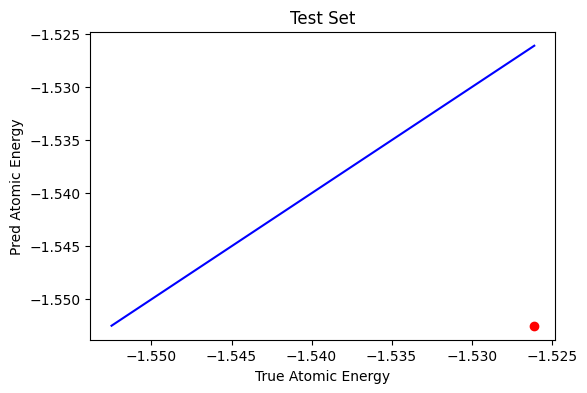

Test MAE: 0.026407966700134233
Test MSE: 0.0006973807052353986
Test MAPE: 1.7304371500826803


In [167]:
# Plot Predicted vs Real on Test Set

y_pred = np.array(ypred).ravel()
y_true = np.array(ytrue).ravel()
#print(y_true.shape)
#print(y_pred.shape)


# Convert to original units
#y_pred = np.array(ypred).ravel()#/100
#y_true = np.array(ytrue).ravel()#/100

#E_avrg = -0.025591339035879856
#E_dev = 2.0321151163332116
#y_pred = np.array(ypred).ravel()*E_dev + E_avrg
#y_true = np.array(ytrue).ravel()*E_dev + E_avrg

plt.figure(figsize=(6,4))
plt.scatter(y_true,y_pred,label = "GNN model",color="red")
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b-')
#plt.plot(np.linspace(-0.2,0.1,50),np.linspace(-0.2,0.1,50))
plt.xlabel("True Atomic Energy")
plt.ylabel("Pred Atomic Energy")
#plt.xlim(-5,0)
#plt.ylim(-5,0)
plt.title("Test Set")
plt.show()

# mean absolute percentage error (MAPE)
def mape(ytrue, ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    
    mape_i = np.zeros(len(ytrue))
    mape_i = np.abs((ypred-ytrue)/ytrue)*100
    mape_i = mape_i[ mape_i < 1e6]

    return np.mean(mape_i)

# Compute metrics (MAPE, MAE, MSE)
print("Test MAE:", mean_absolute_error(y_true,y_pred))
print("Test MSE:", mean_squared_error(y_true,y_pred))
print("Test MAPE:", mape(y_true,y_pred))

